In [1]:
import pandas as pd
import numpy as np
import pickle
import gc
from sklearn.model_selection import train_test_split
import scipy
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Data loading

In [3]:
with open('/content/gdrive/My Drive/Notebooks Colab/cleanKaggleDF.pickle', 'rb') as handle:
    dfTrain, dfTest = pickle.load(handle)

In [4]:
categoricalColumns = list(dfTrain.select_dtypes(exclude='float32').columns)
numericalColumns = list(dfTrain.select_dtypes(include='float32').columns)

# Required classes and functions from dnn.ipynb 

In [5]:
X = dfTrain.copy().drop('HasDetections', 1)
y = dfTrain.copy()['HasDetections']
del dfTrain
xTrain, xVal, yTrain, yVal = train_test_split(X, y, test_size=0.01, stratify=y, random_state=11)

embeddedCols = {n: len(col.cat.categories) for n, col in X.items() if n in categoricalColumns and n!= 'HasDetections' and len(col.cat.categories) > 2}
embeddedColNames = embeddedCols.keys()
nCont = len(X.columns) - len(embeddedCols)
embeddingSizes = [(nCategories, min(50, (nCategories + 1)//2)) for _, nCategories in embeddedCols.items()]
del xTrain
del yTrain

In [6]:
class MalwareDataset(Dataset):
    def __init__(self, X, y, embeddedColNames):
        X = X.copy()
        self.x1 = X.loc[:,embeddedColNames].copy().values.astype(np.int64) # Categorical columns
        self.x2 = X.drop(columns=embeddedColNames).copy().values.astype(np.float32) # Numerical columns
        self.y = y.values.astype(np.float32)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x1[idx], self.x2[idx], self.y[idx]

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def toDevice(data, device):
    if isinstance(data, (list,tuple)):
        return [toDevice(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield toDevice(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [8]:
class MalwareModel(nn.Module):
    def __init__(self, embbedingSizes, nCont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embbedingSizes])
        nEmb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.nEmb, self.nCont = nEmb, nCont
        self.lin1 = nn.Linear(self.nEmb + self.nCont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 1)
        self.bn1 = nn.BatchNorm1d(self.nCont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        self.embDrop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, xCat, xCont):
        x = [e(xCat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.embDrop(x)
        x2 = self.bn1(xCont)
        x = torch.cat([x, x2], 1)
        x = torch.relu(self.bn2(self.lin1(x)))
        x = self.drops(x)
        x = torch.relu(self.bn3(self.lin2(x)))
        x = self.drops(x)
        x = torch.sigmoid(self.lin3(x))
        return x

# Load model

In [9]:
with open('/content/gdrive/My Drive/Notebooks Colab/DNNModel.pickle', 'rb') as handle:
    model = pickle.load(handle)
toDevice(model, device)

MalwareModel(
  (embeddings): ModuleList(
    (0): Embedding(30, 15)
    (1): Embedding(47, 24)
    (2): Embedding(166, 50)
    (3): Embedding(8, 4)
    (4): Embedding(40, 20)
    (5): Embedding(207, 50)
    (6): Embedding(6, 3)
    (7): Embedding(6, 3)
    (8): Embedding(1273, 50)
    (9): Embedding(24, 12)
    (10): Embedding(153, 50)
    (11): Embedding(123, 50)
    (12): Embedding(4, 2)
    (13): Embedding(3, 2)
    (14): Embedding(11, 6)
    (15): Embedding(4, 2)
    (16): Embedding(9, 5)
    (17): Embedding(137, 50)
    (18): Embedding(3, 2)
    (19): Embedding(54, 27)
    (20): Embedding(9, 5)
    (21): Embedding(11, 6)
    (22): Embedding(161, 50)
    (23): Embedding(1551, 50)
    (24): Embedding(4, 2)
    (25): Embedding(751, 50)
    (26): Embedding(102, 50)
    (27): Embedding(5, 3)
    (28): Embedding(723, 50)
    (29): Embedding(25, 13)
    (30): Embedding(21, 11)
    (31): Embedding(166, 50)
    (32): Embedding(38, 19)
    (33): Embedding(33, 17)
    (34): Embedding(9, 5)


# Evaluate accuracy on validation set

In [10]:
valDF = MalwareDataset(xVal, yVal, embeddedColNames)
valDL = DataLoader(valDF, batch_size=1024)
valDL = DeviceDataLoader(valDL, device)
correct = 0
with torch.no_grad():
    for x1, x2, y in valDL:
        prob = model(x1, x2).view(-1) 
        pred = torch.round(prob)
        correct += (pred == y).float().sum().item()
initPerformance = correct/xVal.shape[0]
print(f'Validation accuracy: {initPerformance}')

Validation accuracy: 0.58740122176764


# Compute importances

In [11]:
importances = {}

for column in xVal:
    perturbedXVal = xVal.copy()
    perturbedXVal[column] = np.random.permutation(perturbedXVal[column].values)
    valDF = MalwareDataset(perturbedXVal, yVal, embeddedColNames)
    valDL = DataLoader(valDF, batch_size=1024)
    valDL = DeviceDataLoader(valDL, device)
    correct = 0
    with torch.no_grad():
        for x1, x2, y in valDL:
            prob = model(x1, x2).view(-1) 
            pred = torch.round(prob)
            correct += (pred == y).float().sum().item()
    importances[column] = initPerformance - correct/xVal.shape[0]
    print(f'{column}: {importances[column]}')

with open('/content/gdrive/My Drive/Notebooks Colab/DNNImportances.pickle', 'wb') as handle:
    pickle.dump(importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

EngineVersion: -0.0003923107100823886
AppVersion: 0.004797399540436009
AvSigVersion: 0.00013450652917113004
RtpStateBitfield: 3.362663229278251e-05
DefaultBrowsersIdentifier: 0.0002802219357731506
AVProductStatesIdentifier: 0.008025556240542464
AVProductsInstalled: 0.0006501148909936472
AVProductsEnabled: 3.362663229278251e-05
CityIdentifier: 0.0010200078462142548
OrganizationIdentifier: 0.00011208877430923803
GeoNameIdentifier: 0.0012329765174018403
LocaleEnglishNameIdentifier: 0.0009751723364904707
Platform: 2.2417754861892014e-05
Processor: -0.00022417754861847605
OsBuild: 7.846214201645552e-05
OsSuite: 0.00013450652917113004
OsPlatformSubRelease: 0.00021296867118758556
OsBuildLab: 0.001759793756655248
IsProtected: 0.0
IeVerIdentifier: 0.0012329765174018403
SmartScreen: 0.05969848119710808
Census_MDC2FormFactor: 1.1208877430890496e-05
Census_OEMNameIdentifier: 0.0005492349941152996
Census_OEMModelIdentifier: 0.00019055091632569354
Census_ProcessorManufacturerIdentifier: 0.0001232976

Text(0, 0.5, 'Features')

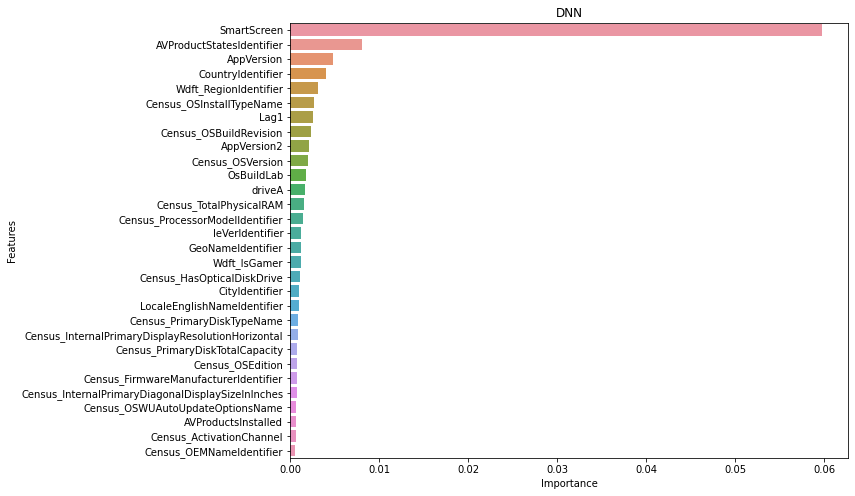

In [12]:
importancesDF = pd.DataFrame({'Features': importances.keys(), 'Importances': importances.values()})
importancesDF.sort_values('Importances', inplace=True, ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(x=importancesDF.iloc[:30, :]['Importances'], y=importancesDF.iloc[:30, :]['Features'])
plt.title('DNN')
plt.xlabel('Importance')
plt.ylabel('Features')